In [2]:
%load_ext autoreload
%autoreload 2

# Getting plots 

In [11]:
import numpy as np 
import emcee
import corner

import matplotlib.pyplot as plt

from mcmc_utils_copy import posteriors, get_cov, corner_plot, check_convergence, lnprob

In [8]:
def load_sampler(r, samplers = None, ind = 0):

    if samplers is None: 
        samplers = np.load(f"runs/run {r}/samplers.npy", allow_pickle=True)

    return samplers[ind]

def grab_plots(r, samplers = None, offset = 0 ):

    if samplers is None: 
        samplers = np.load(f"runs/run {r}/samplers.npy", allow_pickle=True)

    for i in range(len(samplers)):

        s = samplers[i]
        cov = get_cov(s, show = True)
        plt.savefig(f"runs/run {r}/{i+ offset}_cov_matrix.png")
        plt.close()

        fig = corner_plot(s)
        fig.savefig(f"runs/run {r}/{i+ offset}_corner.png")
        plt.close(fig)

        check_convergence(s)
        plt.savefig(f"runs/run {r}/{i+ offset}_convergence.png")
        plt.close()

        posteriors(s, i+ offset)
        plt.savefig(f"runs/run {r}/{i+ offset}_posteriors.png")
        plt.close()

        print(f"Star {i+ offset} is done.")

    return samplers

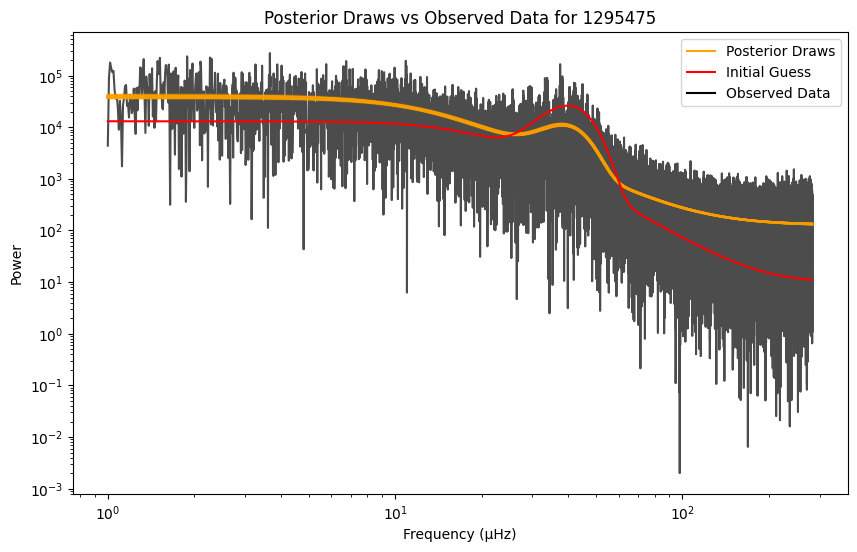

In [12]:
sampler = load_sampler(15, ind = 9 )
fig = posteriors(sampler, 29)

In [ ]:
path = "runs/run 16/results.npy"
results = np.load(path, allow_pickle=True)

# Looking at Covariances

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
from IPython.display import HTML
import numpy as np

In [4]:
def animate_covariances(cov_list, save_path=None, interval=1000):

    param_names = ["nu_max", "H", "P", "tau", "alpha", "W"]

    fig, ax = plt.subplots(figsize=(6,6))
    discrete_viridis = ListedColormap(plt.cm.seismic(np.linspace(0, 1, 9)))

    im = ax.matshow(cov_list[0], cmap=discrete_viridis, vmin=-1, vmax=1)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_xticks(np.arange(len(param_names)))
    ax.set_xticklabels(param_names, rotation=90)
    ax.set_yticks(np.arange(len(param_names)))
    ax.set_yticklabels(param_names)
    title = ax.set_title("Correlation Matrix (Star 0)", pad=20)
    plt.draw_if_interactive()

    def update(frame):
        im.set_data(cov_list[frame])
        title.set_text(f"Correlation Matrix (Star {frame})")
        return [im, title]

    ani = animation.FuncAnimation(fig, update, frames=len(cov_list), interval=interval, blit=False)

    if save_path:
        if save_path.endswith(".gif"):
            ani.save(save_path, writer="pillow", fps=1000//interval)
        elif save_path.endswith(".mp4"):
            ani.save(save_path, writer="ffmpeg", fps=1000//interval)
        else:
            raise ValueError("Unsupported file format. Use .gif or .mp4")

    plt.close(fig) 
    return HTML(ani.to_jshtml())


In [ ]:
cov_list1 = np.array(np.load("runs/run 13/cov_matrices.npy"))
cov_list2 = np.array(np.load("runs/run 14/cov_matrices.npy"))
cov_list3 = np.array(np.load("runs/run 15/cov_matrices.npy"))

cov_list1[2] = TBA
cov_list1[5] = TBA
cov_list1[7] = TBA

cov_list2[2] = np.array(np.load("runs/run 16/cov_matrices.npy"))[0] #this one has fucked up W but idc atp
cov_list2[3] = np.array(np.load("runs/run 16/cov_matrices.npy"))[1]
cov_list2[6] = np.array(np.load("runs/run 17/cov_matrices.npy"))[0]
cov_list2[7] = np.array(np.load("runs/run 17/cov_matrices.npy"))[1]

cov_list3[4] = TBA
cov_list3[6] = TBA
cov_list3[7] = TBA

cov_list1 = np.delete(cov_list1, [2, 5, 7])
cov_list3 = np.delete(cov_list1, [4, 6, 7])

cov_list = (np.concat((cov_list1, cov_list2, cov_list3)))

animate_covariances(cov_list, save_path="covariances1.gif", interval=1000)

In [66]:
def matrix_element(n, m, printt = False, plot = False):
    Mnm = cov_list[:, n, m]
    mu , std = np.mean(Mnm) ,  np.std(Mnm)

    if printt: 
        print(f"mean of M{n, m}: {mu}")
        print(f"std of M{n, m}: {std}")

    if plot:
        plt.hist(Mnm , bins = 7)

    return Mnm, mu, std

In [49]:
inds = []

for ii in range(6):
    for jj in range(ii):
        if not (ii == jj):
            m , mean , std = matrix_element(ii, jj)

            if (np.abs(std) < 0.3):
                print(ii , jj, mean, std )
                inds.append([ii, jj])

1 0 -0.37672065980097635 0.06131421739222421
2 0 -0.004417511180100085 0.0609711908461272
2 1 0.12168795088509562 0.09339261523267979
3 0 -0.02631181448812555 0.09611952778626622
3 1 0.24761987885945538 0.16381108737889874
3 2 0.8312256140094869 0.03863123136632117
4 0 0.07115596867036371 0.10356349590928347
4 1 -0.22106380953695925 0.22722226784436905
4 2 -0.5468367148710258 0.04203780266478841
4 3 -0.8814083099993976 0.0267422060661723
5 0 0.05646043057619187 0.047491393834580224
5 1 -0.03670253761152979 0.13562090336081695
5 2 -0.22533164844364048 0.07578953501985074
5 3 -0.36066337311730673 0.08574408507199421
5 4 0.5232674940825582 0.10884006646676797
